# Imports

In [13]:
import matplotlib.pyplot as plt

import torch
import torchvision.transforms as transforms

from src.data.tiny_imagenet_dataset import SmallImageNetTrainDataset

# Data

In [14]:
transform = transforms.Compose([
        transforms.Resize((512, 512)),
        # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = SmallImageNetTrainDataset(
        root_dir=r"/Users/egorprokopov/Documents/ITMO/BachelorThesis/data/small_imagenet_object_loc/train",
        classes_names_path=r"/Users/egorprokopov/Documents/ITMO/BachelorThesis/data/small_imagenet_object_loc/classes_names.txt",
        transform=transform
)

In [15]:
sample = dataset[0]
image = sample["image"]
label = sample["label_encoded"]
image_tag = sample["tag"]

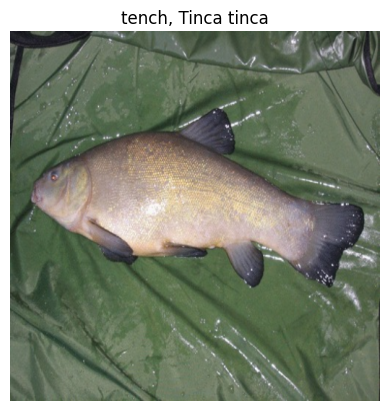

In [16]:
plt.title(f"{dataset.classes_names[image_tag]}")
plt.axis('off')
plt.imshow(image.permute(1, 2, 0).cpu().numpy(), cmap="gray" if image.shape[0] == 1 else None)

# SVD

In [17]:
image.shape

torch.Size([3, 512, 512])

In [18]:
from src.tokenizers.svd_tokenizer import SVDTokenizer

In [19]:
img_batch = image.unsqueeze(0)

In [20]:
tokenizer = SVDTokenizer(image_size=512, embedding_dim=768, dispersion=0.65)
embedding = tokenizer(img_batch)
embedding.shape

RuntimeError: The size of tensor a (3) must match the size of tensor b (512) at non-singleton dimension 2

In [21]:
approx_U, approx_S, approx_V, rank = tokenizer.get_approx_svd(image)

In [22]:
reconstructed_image = tokenizer.reconstruct_image(approx_U, approx_S, approx_V)
reconstructed_image.shape

torch.Size([3, 512, 512])

In [23]:
# rank = 50
# 
# approx_image_channels = []
# for image_channel in image:
#     U, S, Vh = torch.linalg.svd(image_channel)
#     approx_image_channel = (U[:, :rank] @ torch.diag(S[:rank]) @ Vh[:rank, :])
#     approx_image_channels.append(approx_image_channel)
#     
# approx_image = torch.stack(approx_image_channels)


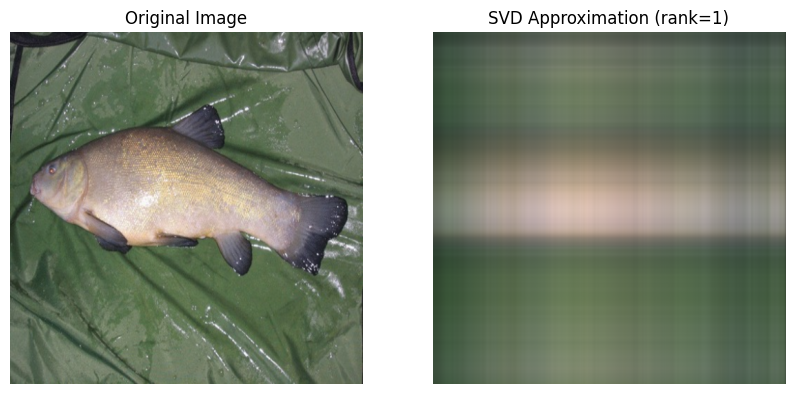

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(image.permute(1, 2, 0).cpu().numpy(), cmap="gray" if image.shape[0] == 1 else None)
axes[0].set_title("Original Image")
axes[0].axis("off")

axes[1].imshow(reconstructed_image.permute(1, 2, 0).cpu().numpy(), cmap="gray" if image.shape[0] == 1 else None)
axes[1].set_title(f"SVD Approximation (rank={rank})")
axes[1].axis("off")

plt.show()

# SVD dispersion

In [25]:
U, S, Vh = torch.linalg.svd(image, full_matrices=True)
Vh = Vh.mH

## Linear

In [26]:
S_sum = S.sum(dim=0, keepdim=True)

S_cumsum = torch.cumsum(S_sum, dim=1)
total_sum = S_sum.sum()

S_cumsum_norm = S_cumsum / total_sum

In [27]:
S_cumsum_norm_lin = S_cumsum_norm.squeeze().numpy()

## Quadratic

In [28]:
S_squared = torch.square(S)
S_squared = S_squared.sum(dim=0, keepdim=True)

S_cumsum = torch.cumsum(S_squared, dim=1)
total_sum = S_squared.sum()

S_cumsum_norm = S_cumsum / total_sum

In [29]:
S_cumsum_norm_quad = S_cumsum_norm.squeeze().numpy()

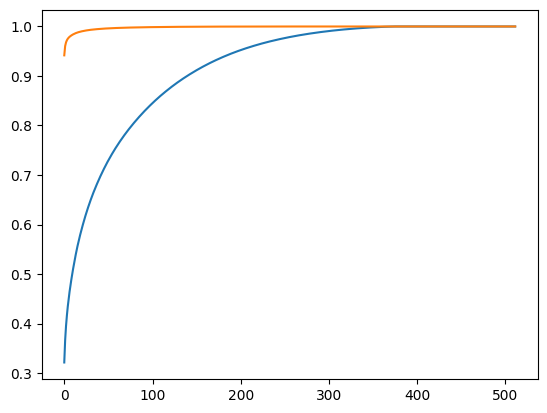

In [30]:
plt.plot(S_cumsum_norm_lin)
plt.plot(S_cumsum_norm_quad)